In [1]:
import os
import pandas as pd

def preprocess_data(data_dir, data_type):
    image_paths = []
    labels = []
    folds = os.listdir(data_dir)

    for fold in folds:
        fold_path = os.path.join(data_dir, fold)
        if os.path.isdir(fold_path):
            filelist = os.listdir(fold_path)
            image_paths.extend(os.path.join(fold_path, file) for file in filelist)
            labels.extend([fold] * len(filelist))
        else:
            print(f"Skipping non-directory: {fold_path}")

    df = pd.DataFrame({'filepaths': image_paths, 'label': labels})
    df['data_type'] = data_type
    return df

# Define the directories containing data
training_dir = "./brain_tumor_dataset/training/"
test_dir = './brain_tumor_dataset/test/'

# Preprocess the training data
train_df = preprocess_data(training_dir, 'train')

# Preprocess the test data
test_df = preprocess_data(test_dir, 'test')


In [2]:
import plotly.express as px

def plot_histogram(df, title):
    figure = px.histogram(
        df,
        y='label',
        color='label',
        template='plotly',
        title=title
    )
    figure.show()

# Plot histogram for training data
plot_histogram(train_df, 'Number of Images in Each Class of the Training Fold')

# Plot histogram for test data
plot_histogram(test_df, 'Number of Images in Each Class of the Test Fold')


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def setup_data_generators(df, test_size=0.5, img_size=(224, 244), batch_size=16, random_state=42):
    train, test = train_test_split(df, test_size=test_size, shuffle=True, random_state=random_state)
    
    # Shuffle the validation set to ensure randomness
    valid = shuffle(test, random_state=random_state)
    
    tr_gen = ImageDataGenerator()
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(
        train,
        x_col='filepaths',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid,
        x_col='filepaths',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test,
        x_col='filepaths',
        y_col='label',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=batch_size
    )

    return train_gen, valid_gen, test_gen

# Usage example:
train_gen, valid_gen, test_gen = setup_data_generators(train_df)



Found 2856 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.


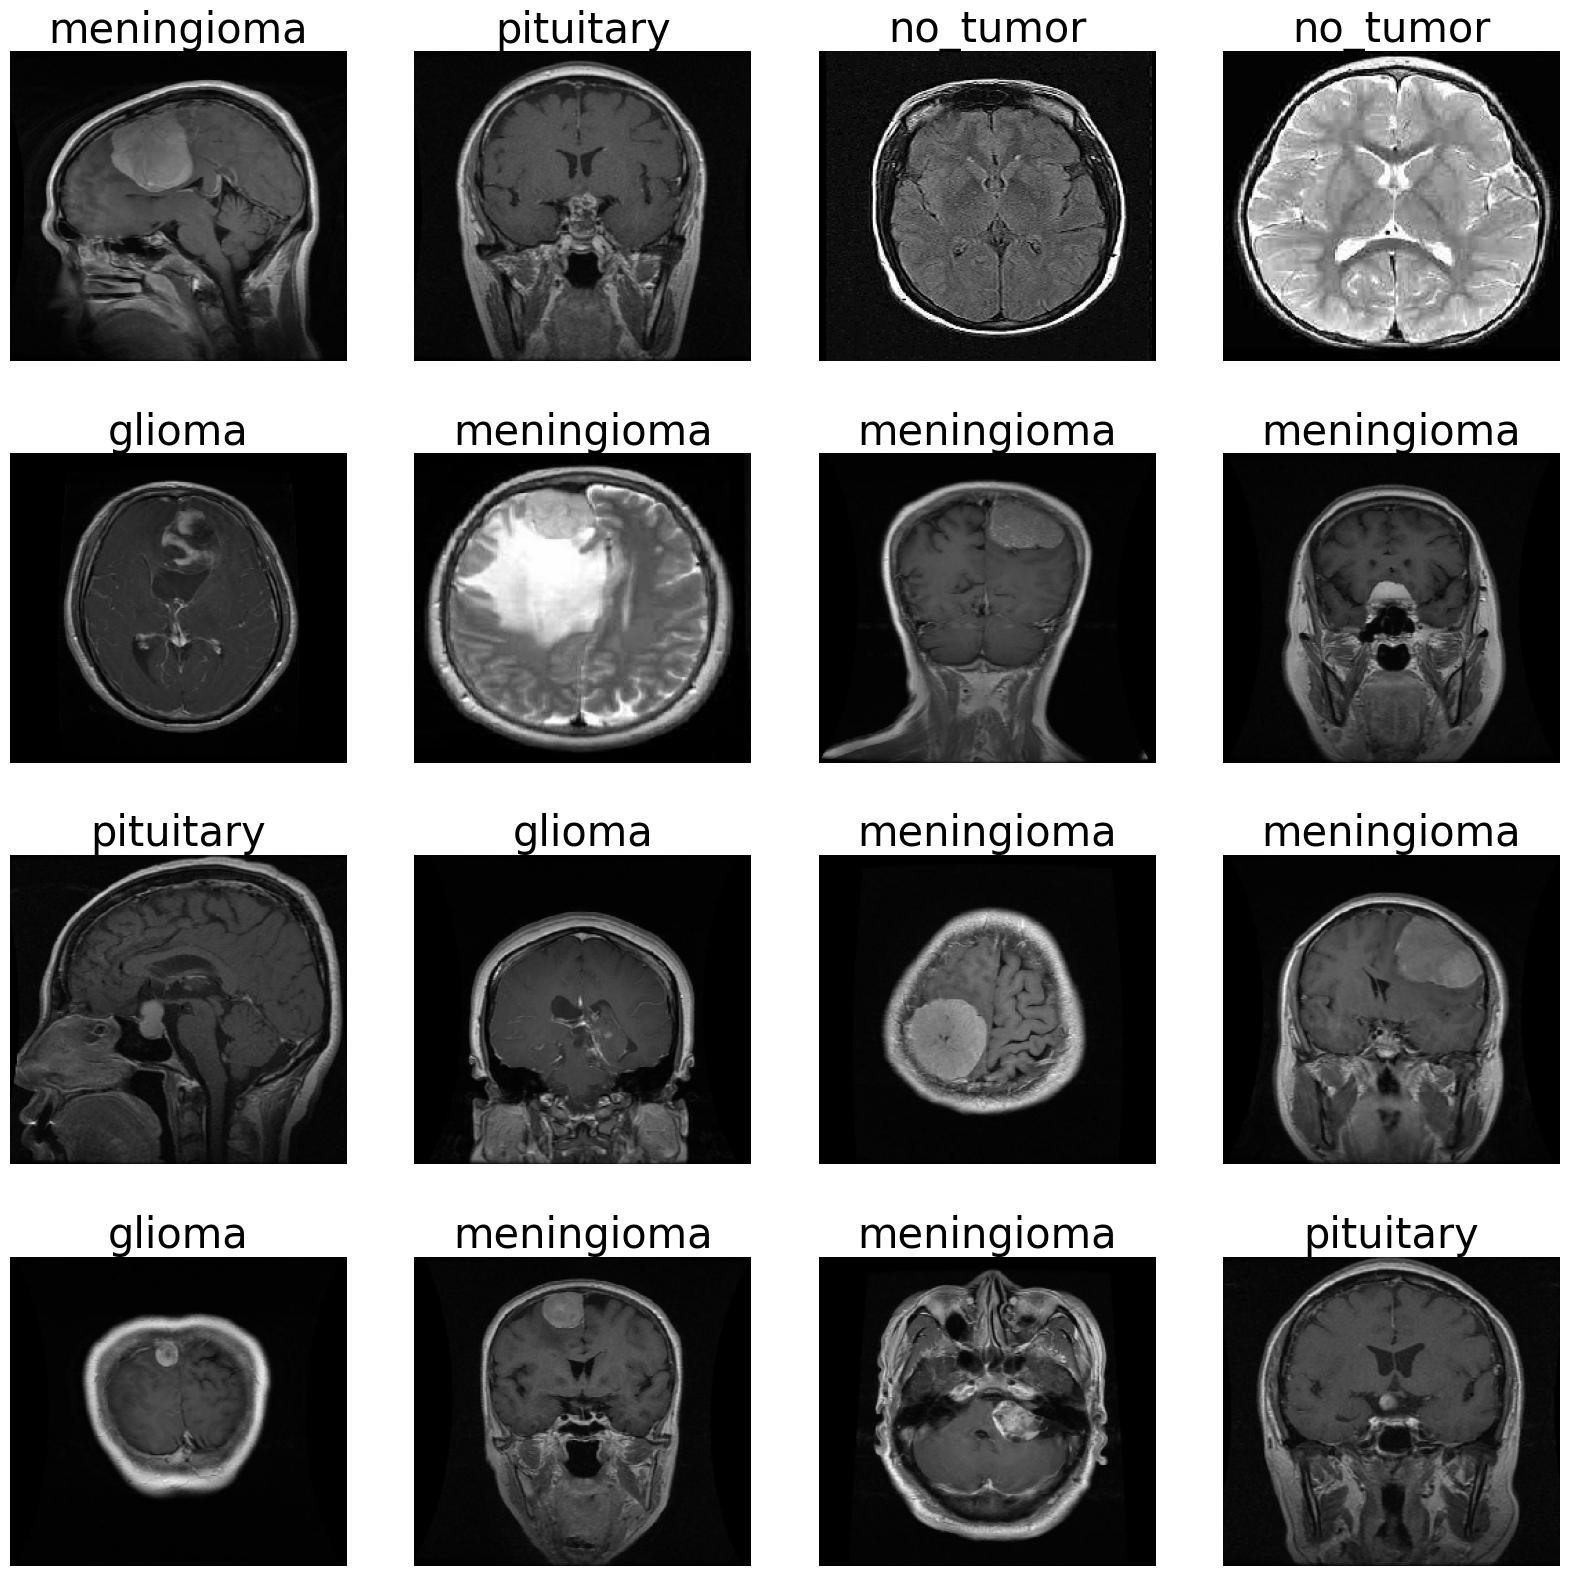

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get class indices and names
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())

# Load a batch of images and labels
images , labels = next(train_gen)

plt.figure(figsize=(20, 20))
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i + 1)
    # Normalize image and display
    plt.imshow(image / 255)
    # Extract class name using list comprehension
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='black', fontsize=30)
    plt.axis('off')

plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

def build_model(img_size, num_classes):
    # Define model configurations
    img_shape = (img_size[0], img_size[1], 3)
    
    # Load base model
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=img_shape,
        pooling='max'
    )

    # Build model architecture
    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.4, seed=75),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the input image size
img_size = (224, 224)  # Example size, adjust according to your data

# Define the number of output classes
num_classes = len(train_df['label'].unique())

# Build and display model summary
model = build_model(img_size, num_classes)
model.summary()

# Define the new file path where you want to save the model
model_path = "C:/Users/Monet/Desktop/Tumor_SW-Registration-2024-SUN XIAOYING/model.h5"

# Save the model
model.save(model_path)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

c:\Users\Monet\anaconda3\envs\bone-age\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [7]:
def train_model(model, train_gen, valid_gen, epochs=10):
    # Define callbacks for model training
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("C:/Users/Monet/Desktop/Tumor_SW-Registration-2024-SUN XIAOYING/checkpoint/checkpoint.keras", save_best_only=True)
    ]
    
    # Train the model
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        verbose=1,
        validation_data=valid_gen,
        callbacks=callbacks
    )
    
    return history

# Train the model
history = train_model(model, train_gen, valid_gen, epochs=10)

Epoch 1/10
179/179 [==============================] - 601s 3s/step - loss: 7.0665 - accuracy: 0.8277 - val_loss: 5.7872 - val_accuracy: 0.9093
Epoch 2/10
179/179 [==============================] - 584s 3s/step - loss: 4.7055 - accuracy: 0.9356 - val_loss: 3.9695 - val_accuracy: 0.9464
Epoch 3/10
179/179 [==============================] - 587s 3s/step - loss: 3.3019 - accuracy: 0.9664 - val_loss: 2.8090 - val_accuracy: 0.9569
Epoch 4/10
179/179 [==============================] - 590s 3s/step - loss: 2.3545 - accuracy: 0.9737 - val_loss: 1.9595 - val_accuracy: 0.9688
Epoch 5/10
179/179 [==============================] - 580s 3s/step - loss: 1.6460 - accuracy: 0.9867 - val_loss: 1.3945 - val_accuracy: 0.9737
Epoch 6/10
179/179 [==============================] - 569s 3s/step - loss: 1.1561 - accuracy: 0.9902 - val_loss: 0.9996 - val_accuracy: 0.9678
Epoch 7/10
179/179 [==============================] - 585s 3s/step - loss: 0.8100 - accuracy: 0.9933 - val_loss: 0.7096 - val_accuracy: 0.9709

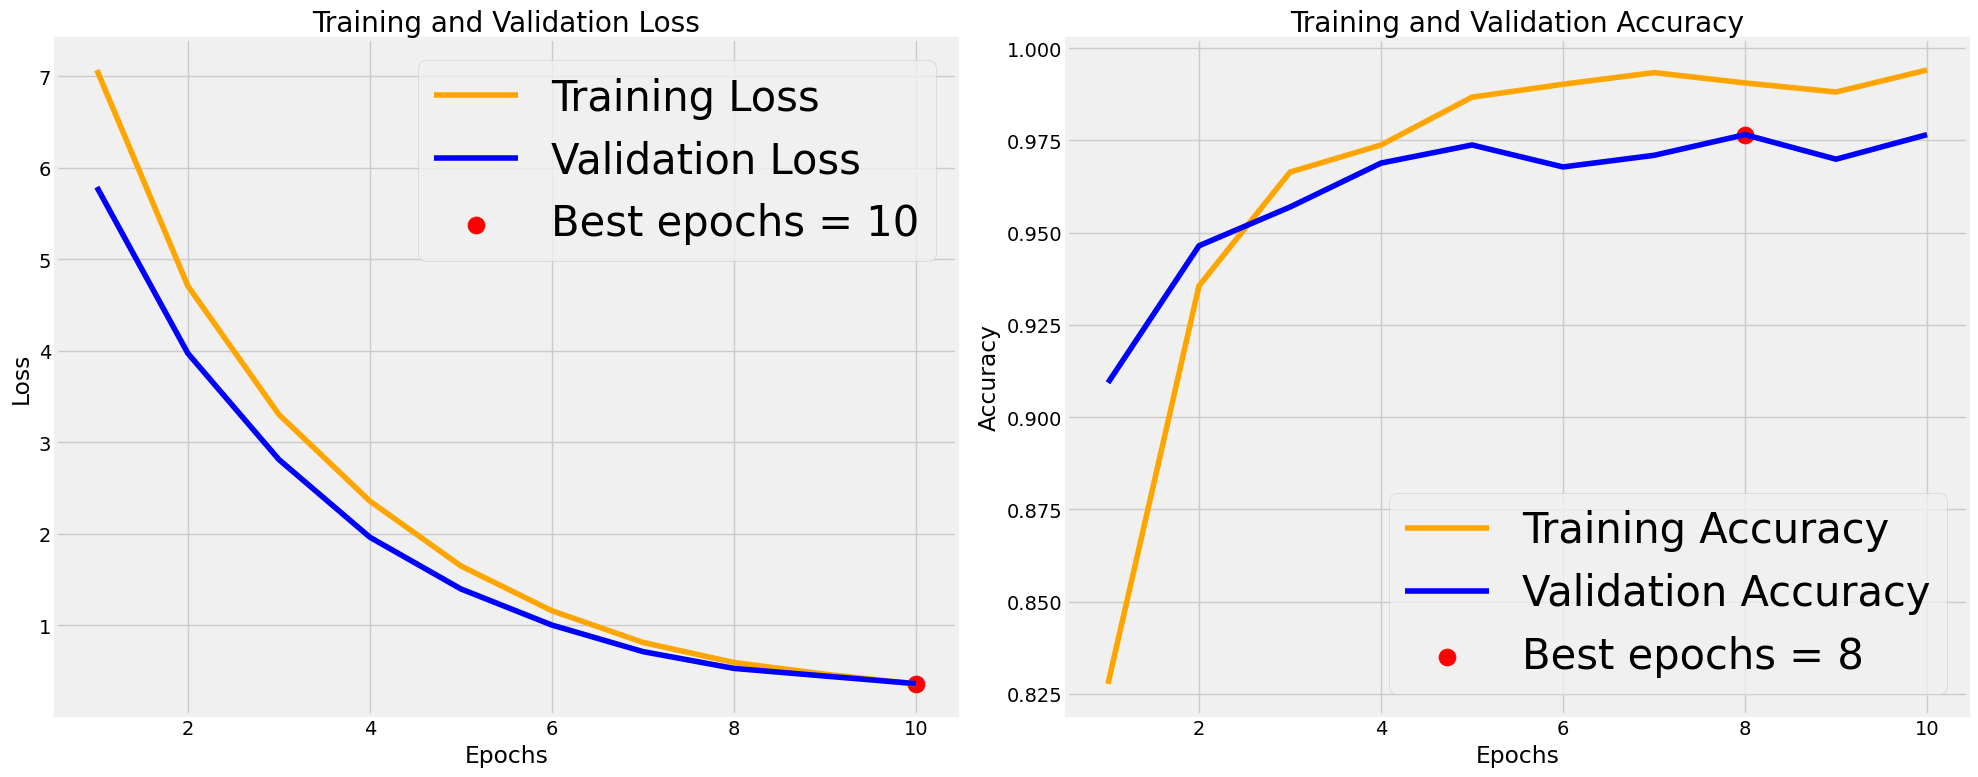

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_history(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    index_acc = np.argmax(val_acc)
    val_highest = val_acc[index_acc]

    epochs = range(1, len(train_acc) + 1)

    loss_label = f'Best epochs = {str(index_loss + 1)}'
    acc_label = f'Best epochs = {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'orange', label='Training Loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='red', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize=30)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'orange', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
    plt.scatter(index_acc + 1, val_highest, s=150, c='red', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize=30)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


In [9]:
def evaluate_model(model, generator):
    scores = model.evaluate(generator, verbose=1)
    loss = scores[0]
    accuracy = scores[1]
    return loss, accuracy

# Evaluate the model on training, validation, and test sets
train_loss, train_accuracy = evaluate_model(model, train_gen)
valid_loss, valid_accuracy = evaluate_model(model, valid_gen)
test_loss, test_accuracy = evaluate_model(model, test_gen)

# Print evaluation results
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print('-' * 20)
print("Validation Loss:", valid_loss)
print("Validation Accuracy:", valid_accuracy)
print('-' * 20)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


179/179 [==============================] - 101s 566ms/step - loss: 0.3596 - accuracy: 0.9765
Train Loss: 0.28817319869995117
Train Accuracy: 0.9985994100570679
--------------------
Validation Loss: 0.359622985124588
Validation Accuracy: 0.9765406250953674
--------------------
Test Loss: 0.35962289571762085
Test Accuracy: 0.9765406250953674


In [10]:
# ************************************************************************
# *
# *    Function Name: Predictions
# *    Version: V1.0
# *    Author: SUN XIAOYING
# *    Create Time: 2024-02-29
# *
# *************************************************************************

def generate_predictions(model, generator):
    """
    Generate predictions using the provided model and data generator.

    Args:
    model (tf.keras.Model): The trained model.
    generator (tf.keras.preprocessing.image.DataFrameIterator): Data generator for prediction.

    Returns:
    np.ndarray: Predicted class labels.
    """
    # Ensure generator is set to shuffle=False for consistent predictions
    generator.shuffle = False
    
    # Generate predictions
    predictions = model.predict(generator)
    
    # Extract predicted class labels
    y_prediction = np.argmax(predictions, axis=1)
    
    return y_prediction

# Generate predictions using the model
predictions = generate_predictions(model, test_gen)


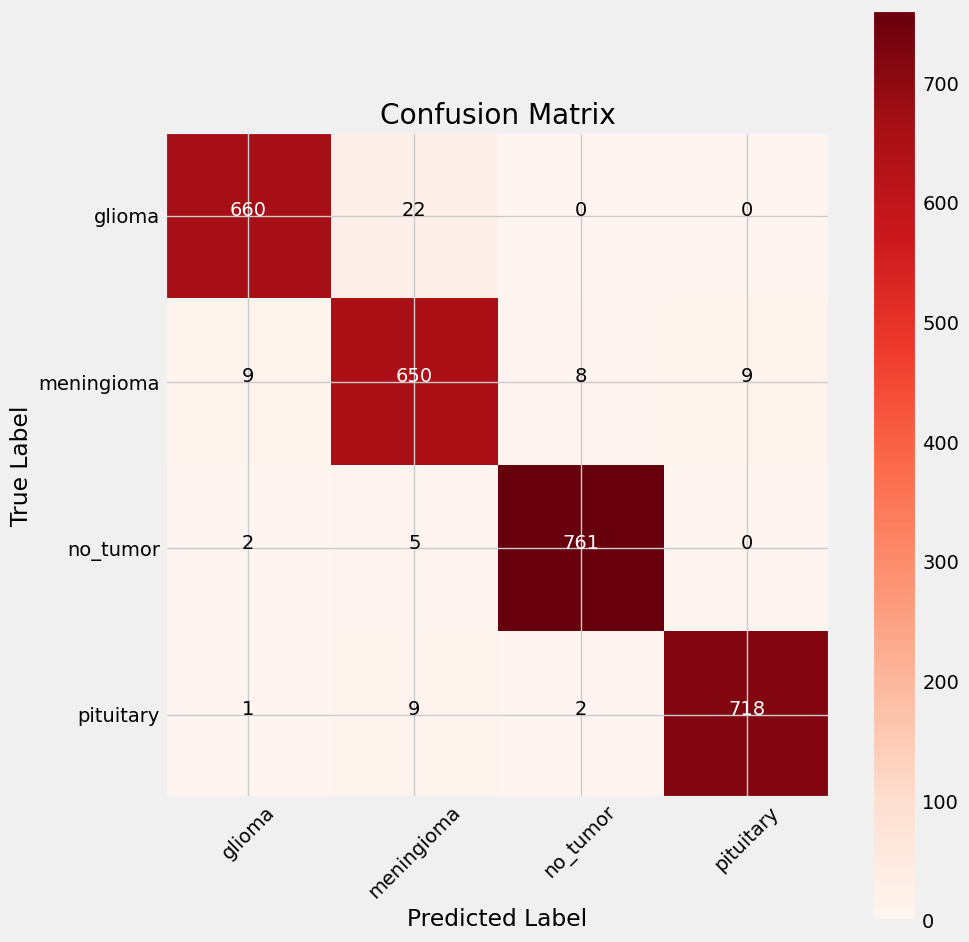

In [11]:
# ************************************************************************
# *
# *    Function Name: Confusion Matrix and Classification
# *    Version: V2.0
# *    Author: SUN XIAOYING
# *    Create Time: 2024-02-29
# *
# *************************************************************************

import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes):
    """
    Plot the confusion matrix.

    Args:
    cm (np.ndarray): Confusion matrix.
    classes (list): List of class labels.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Compute the confusion matrix
cm = confusion_matrix(test_gen.classes, predictions)

# Plot the confusion matrix
plot_confusion_matrix(cm, classes)

In [12]:
import pandas as pd
from sklearn.metrics import classification_report

def classification_report_to_dataframe(y_true, y_pred, classes):
    """
    Generate a DataFrame representation of the classification report.

    Args:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    classes (list): List of class labels.

    Returns:
    pd.DataFrame: DataFrame containing the classification report.
    """
    # Generate the classification report with percentages
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

    # Convert the report to DataFrame
    df = pd.DataFrame(report).transpose()

    # Format percentages
    df['precision'] = df['precision'].map(lambda x: f"{x*100:.2f}%")
    df['recall'] = df['recall'].map(lambda x: f"{x*100:.2f}%")
    df['f1-score'] = df['f1-score'].map(lambda x: f"{x*100:.2f}%")

    return df

# Convert classification report to DataFrame
classification_df = classification_report_to_dataframe(test_gen.classes, predictions, classes)

# Display the DataFrame
print(classification_df)


             precision  recall f1-score      support
glioma          98.21%  96.77%   97.49%   682.000000
meningioma      94.75%  96.15%   95.45%   676.000000
no_tumor        98.70%  99.09%   98.90%   768.000000
pituitary       98.76%  98.36%   98.56%   730.000000
accuracy        97.65%  97.65%   97.65%     0.976541
macro avg       97.61%  97.59%   97.60%  2856.000000
weighted avg    97.67%  97.65%   97.66%  2856.000000
